In [25]:
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset folders
dataset_list = ['A', 'B1', 'B2', 'C', 'D']
base_path = './test_data'

# Quality labels to predict
quality_labels = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']

# Collect all merged CSVs
all_dfs = []
print("Loading CSV files...")
for dataset in tqdm(dataset_list, desc="Datasets"):
    path_pattern = os.path.join(base_path + dataset, 'MERGED_FILES', '*.csv')  # <-- match all CSVs
    # print(f"Searching in: {path_pattern}")
    for file_path in glob(path_pattern):
        try:
            df = pd.read_csv(file_path, dtype=str)
            # print(f"Loaded {file_path} with shape {df.shape}")
            df['source_dataset'] = dataset  # Optional: keep track of source
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
# # Combine all data

Loading CSV files...


Datasets: 100%|██████████| 5/5 [00:47<00:00,  9.54s/it]


In [48]:
print("Combining CSVs into one DataFrame...")
data = pd.concat(all_dfs, ignore_index=True)
print(f"Total rows loaded: {len(data)}")

# Drop rows with missing target values
quality_to_index = {q: i for i, q in enumerate(quality_labels)}
data['PlaybackQuality'] = data[quality_labels].idxmax(axis=1).map(quality_to_index)
print("Filtering out rows with no quality label...")
data = data.dropna(subset=['PlaybackQuality'])

Combining CSVs into one DataFrame...
Total rows loaded: 3377080
Filtering out rows with no quality label...


In [49]:
# Wrap in tqdm for progress bar
for col in tqdm(data.columns, desc="Converting columns to numeric"):
    data[col] = pd.to_numeric(data[col], errors='ignore')
print(data)


Converting columns to numeric:   0%|          | 0/209 [00:00<?, ?it/s]C:\Users\richa\AppData\Local\Temp\ipykernel_23516\2823535155.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data[col] = pd.to_numeric(data[col], errors='ignore')
Converting columns to numeric: 100%|██████████| 209/209 [02:52<00:00,  1.22it/s]


         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        217              0   
1                 0.1          106               87      14518          59415   
2                 0.2            6                0       1944              0   
3                 0.3            8                1       2350            102   
4                 0.4            7                0       2268              0   
...               ...          ...              ...        ...            ...   
3377075        1800.5            0                0          0              0   
3377076        1800.6            0                0          0              0   
3377077        1800.7            0                0          0              0   
3377078        1800.8            0                0          0              0   
3377079        1800.9            0                0          0              0   

                 IPSrc0    

In [50]:
# Drop original quality columns
data = data.drop(columns=quality_labels)
print(data)
# # Drop non-numeric BECAUSE RF DOESNT WORK ON NON NUMERICS
# non_feature_cols = ['IPSrc0', 'IPDst0', 'Protocol0', 'source_dataset',
#                     'CollectData', 'StartTime', 'UnlabelledQuality']
# data = data.drop(columns=[col for col in non_feature_cols if col in data.columns], errors='ignore')

# # Remove IP and protocol columns (non-numeric)
# data = data[[col for col in data.columns if not any(proto in col for proto in ['IPSrc', 'IPDst', 'Protocol'])]]

# Drop any remaining non-numeric columns
data = data.select_dtypes(include=['number', 'bool'])
print(data)

         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        217              0   
1                 0.1          106               87      14518          59415   
2                 0.2            6                0       1944              0   
3                 0.3            8                1       2350            102   
4                 0.4            7                0       2268              0   
...               ...          ...              ...        ...            ...   
3377075        1800.5            0                0          0              0   
3377076        1800.6            0                0          0              0   
3377077        1800.7            0                0          0              0   
3377078        1800.8            0                0          0              0   
3377079        1800.9            0                0          0              0   

                 IPSrc0    

In [51]:

# Encode labels
le = LabelEncoder()
data['PlaybackQuality'] = le.fit_transform(data['PlaybackQuality'])

# Separate features and labels
X = data.drop(columns=['PlaybackQuality'])
y = data['PlaybackQuality']


In [53]:
print(y)
print(X)

0          0
1          0
2          0
3          0
4          0
          ..
3377075    0
3377076    0
3377077    0
3377078    0
3377079    0
Name: PlaybackQuality, Length: 3377080, dtype: int64
         RelativeTime  PacketsSent  PacketsReceived  BytesSent  BytesReceived  \
0                 0.0            1                0        217              0   
1                 0.1          106               87      14518          59415   
2                 0.2            6                0       1944              0   
3                 0.3            8                1       2350            102   
4                 0.4            7                0       2268              0   
...               ...          ...              ...        ...            ...   
3377075        1800.5            0                0          0              0   
3377076        1800.6            0                0          0              0   
3377077        1800.7            0                0          0             

In [56]:

# Split
print("Splitting into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
print("Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=10, random_state=42)
for i in tqdm(range(1), desc="Training"):
    clf.fit(X_train, y_train)

# Evaluate
print("\nEvaluating model...")
y_pred = clf.predict(X_test)

Splitting into training and test sets...
Training Random Forest Classifier...


Training: 100%|██████████| 1/1 [00:58<00:00, 58.13s/it]



Evaluating model...



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111638
           1       0.99      1.00      0.99     82451
           2       1.00      0.99      0.99     88683
           3       1.00      1.00      1.00    110879
           4       1.00      1.00      1.00    169944
           5       1.00      1.00      1.00    111821

    accuracy                           1.00    675416
   macro avg       1.00      1.00      1.00    675416
weighted avg       1.00      1.00      1.00    675416



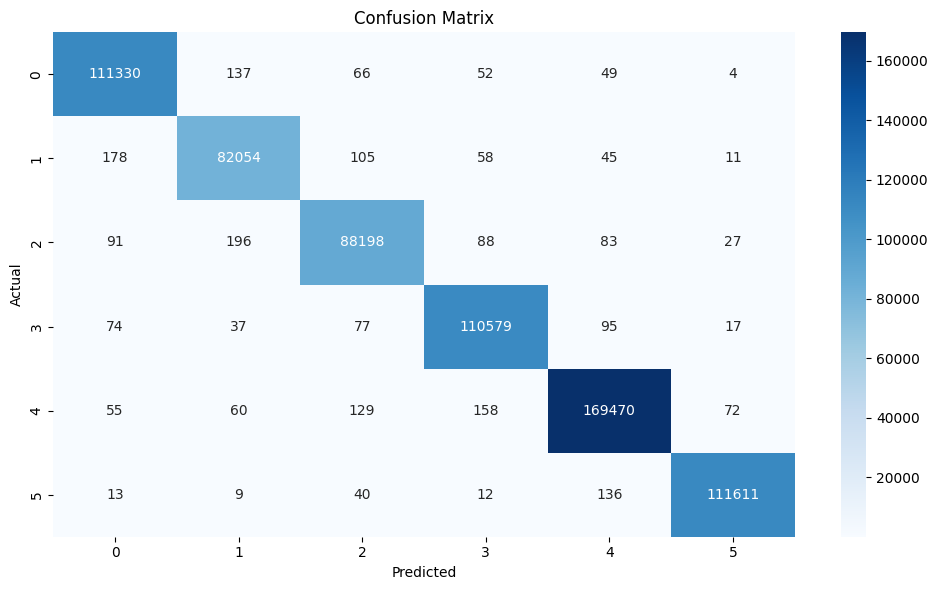

In [58]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))
# Convert the integer labels back to string labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

# Classification report with string labels
print("\nClassification Report:")
print(classification_report(y_test_str, y_pred_str, target_names=le.classes_.astype(str)))
# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [61]:
from trustee import ClassificationTrustee

# Apply ClassificationTrustee
trustee = ClassificationTrustee(expert=clf)

# Fit the trustee model to the training data
trustee.fit(X_train, y_train, num_iter=2, num_stability_iter=2, samples_size=0.3, verbose=True)

# Get the explanation (decision tree and other metrics)
dt, pruned_dt, agreement, reward = trustee.explain()

# Predict using the pruned decision tree
dt_y_pred = dt.predict(X_test)

# Print the global fidelity report
print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))

# Print the explanation score report
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(n_estimators=10, random_state=42) as expert model
Expert model score: 0.9999547004225859
Initializing Trustee outer-loop with 2 iterations
########## Outer-loop Iteration 0/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 567349 points from training dataset with (1891164, 1891164) entries
Student model 0-0 trained with depth 32 and 504 leaves:
Student model score: 0.9994297857747695
Student model 0-0 fidelity: 0.9994297857747695
########## Inner-loop Iteration 1/2 ##########
Sampling 567349 points from training dataset with (2061369, 2061369) entries
Student model 0-1 trained with depth 33 and 517 leaves:
Student model score: 0.9994856356408257
Student model 0-1 fidelity: 0.9994856356408257
########## Outer-loop Iteration 1/2 ##########
Initializing Trustee inner-loop with 2 iterations
########## Inner-loop Iteration 0/2 ##########
Sampling 567349 points from

c:\Users\richa\Desktop\CodingWorkspaces\293N-YT-ABR-Prediction\requet_trustee_venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111741
           1       0.99      0.99      0.99     82493
           2       0.99      1.00      0.99     88615
           3       1.00      1.00      1.00    110947
           4       1.00      1.00      1.00    169878
           5       1.00      1.00      1.00    111742

    accuracy                           1.00    675416
   macro avg       1.00      1.00      1.00    675416
weighted avg       1.00      1.00      1.00    675416

Model explanation score report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111638
           1       1.00      1.00      1.00     82451
           2       1.00      1.00      1.00     88683
           3       1.00      1.00      1.00    110879
           4       1.00      1.00      1.00    169944
           5       1.00      1.00      1.00    111821

   

In [ ]:
# I've run this and it works up until saving
from trustee.report.trust import TrustReport
OUTPUT_PATH = "./test"
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = y.unique()  # Get unique values from y, which is PlaybackQuality
feature_names = X.columns.tolist()  # Get the column names from the DataFrame for the features

trust_report = TrustReport(
    clf,
    X_train=X_train,  # Pass the training data
    X_test=X_test,  # Pass the testing data
    y_train=y_train,  # Pass the training target values
    y_test=y_test,  # Pass the testing target values
    max_iter=1,  # Minimum iterations for the main process
    num_pruning_iter=1,  # Minimum pruning iterations
    train_size=0.7,
    trustee_num_iter=1,  # Minimum trustee iterations
    trustee_num_stability_iter=1,  # Minimum stability iterations
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=5,  # Analyze top 5 feature importance
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)
print(trust_report)
trust_report.save(OUTPUT_PATH)

Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.9% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.8% Complete
Fitting blackbox model...
Done!
Blackbox model score report with training data:

              precision    recall  f1-score   support

           0      0.996     0.997     0.997    166486
           1      0.995     0.995     0.995    123778
           2      0.996     0.994     0.995    133336
           3      0.996     0.997     0.996    166042
           4      0.997     0.997     0.997    255862
           5      0.999     0.998     0.998    167620

    accuracy                          0.996   1013124
   macro avg      0.996     0.996     0.996   1013124
weighted avg      0.996     0.996     0.996   1013124

Using Classification Trustee algorithm to extract DT...
Initializing t

AttributeError: 'numpy.int64' object has no attribute 'replace'

In [ ]:
# This one might actually work?
from trustee.report.trust import TrustReport

OUTPUT_PATH = "./test"

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

target_names = [str(name) for name in y.unique()]  # Convert target labels to strings
feature_names = X.columns.tolist()  # Feature column names

trust_report = TrustReport(
    clf,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    max_iter=1,
    num_pruning_iter=1,
    train_size=0.7,
    trustee_num_iter=1,
    trustee_num_stability_iter=1,
    trustee_sample_size=0.3,
    analyze_branches=True,
    analyze_stability=True,
    top_k=1,
    verbose=True,
    class_names=target_names,
    feature_names=feature_names,
    is_classify=True,
)

print(trust_report)
trust_report.save(OUTPUT_PATH)


Running Trust Report...
Preparing data...
Done!
Progress |----------------------------------------------------------------------------------------------------| 0.9% Complete
Done!
Progress |█---------------------------------------------------------------------------------------------------| 1.8% Complete
Fitting blackbox model...


KeyboardInterrupt: 

In [70]:
import pickle

# Load the TrustReport object
with open("./test/report/trust_report.obj", "rb") as f:
    trust_report_loaded = pickle.load(f)

# Now you can access its methods or attributes
print(trust_report_loaded)



+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                            Classification Trust Report                                                                                             |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|               +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+                |
|               |                                                                                      Summary                             

findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfon

Plotting...


findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Font family 'Roboto' not found.
findfont: Font family 'Roboto' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfon

AttributeError: 'numpy.int64' object has no attribute 'strip'

findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were foun

<Figure size 3000x300 with 0 Axes>

<Figure size 4000x300 with 0 Axes>

<Figure size 5000x300 with 0 Axes>

<Figure size 5000x300 with 0 Axes>

<Figure size 4000x300 with 0 Axes>

<Figure size 5000x1000 with 0 Axes>

<Figure size 5000x1000 with 0 Axes>

<Figure size 4000x300 with 0 Axes>

<Figure size 5000x1000 with 0 Axes>

<Figure size 5000x1000 with 0 Axes>

<Figure size 4000x300 with 0 Axes>

findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were found: Roboto
findfont: Generic family 'serif' not found because none of the following families were foun

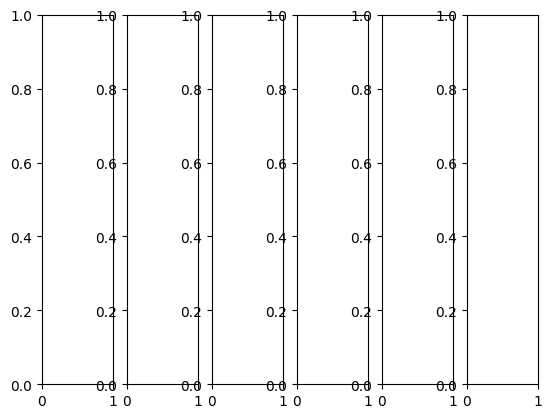

In [ ]:
# Generates shit ton of PDFs in the outputdir errors out a bit
trust_report_loaded.plot("./output_dir")  # Re-plot visuals


In [72]:
print(trust_report_loaded.max_dt)  # Print the decision tree with highest trust
print(trust_report_loaded.feature_names)  # See the feature names


DecisionTreeClassifier(random_state=0)
['RelativeTime', 'PacketsSent', 'PacketsReceived', 'BytesSent', 'BytesReceived', 'PacketsSent0', 'PacketsReceived0', 'BytesSent0', 'BytesReceived0', 'PacketsSent1', 'PacketsReceived1', 'BytesSent1', 'BytesReceived1', 'PacketsSent2', 'PacketsReceived2', 'BytesSent2', 'BytesReceived2', 'PacketsSent3', 'PacketsReceived3', 'BytesSent3', 'BytesReceived3', 'PacketsSent4', 'PacketsReceived4', 'BytesSent4', 'BytesReceived4', 'PacketsSent5', 'PacketsReceived5', 'BytesSent5', 'BytesReceived5', 'PacketsSent6', 'PacketsReceived6', 'BytesSent6', 'BytesReceived6', 'PacketsSent7', 'PacketsReceived7', 'BytesSent7', 'BytesReceived7', 'PacketsSent8', 'PacketsReceived8', 'BytesSent8', 'BytesReceived8', 'PacketsSent9', 'PacketsReceived9', 'BytesSent9', 'BytesReceived9', 'PacketsSent10', 'PacketsReceived10', 'BytesSent10', 'BytesReceived10', 'PacketsSent11', 'PacketsReceived11', 'BytesSent11', 'BytesReceived11', 'PacketsSent12', 'PacketsReceived12', 'BytesSent12', 'By